# Logistic Regression with Gradient Ascent from Scratch #

This notebook contains my implementation of the logistic regression with a gradient Ascent. I have also left the simple code `.py` file in the `code` folder, hoping that it it might be easier to imporve the code with `git`. So, I expect that at some point this notebook might be deprecated, and will be be used mostly as a tutorial.  

Logistic regression is analogous to multiple linear regression, except the outcome is binary (0/1). There is also no closed form solution, and the model is fit using Maximum Likelihood Estimation (MLE). With MLE we are trying to find the model that most likely produced the data we see. I will talk more about the steps we need to take when we start building our algorithm.   

Logistic Regression is used for classification, which is a very important task in Machine Learning. It is part of the Supervised Learning techniques, where we use part of the known data to to learn the best model and parameters that fit our data. The known data comes as pairs of inputs ($X$) and outputs ($y$) to be able to train a model, and it is used in many applications. 

So, we have an input with its attribute set (variables) and we use the classification algorithm to learn how to assign class labels to these examples.  

Classification is a form of prediction where the goal is to predict the class labels, whether if it is binary or multiclass. In this example we will use the UCI Machine Learning Repository [Gisette](https://archive.ics.uci.edu/ml/datasets/Gisette) dataset. This dataset is a handwritten digit problem, where we want to separate the highly confusible digits '4' and '9', and it was constructed from the well known MNIST dataset. Since we only want to discriminate between '4' and '9', this is a binary classification problem.  

***

### Train and validation sets ###

In order to be able to see how good our model is we need to have samples for training it and another set of samples, not "seen" by the model, to infer how well it generalizes to unseen data. Normally we would use `sklearn` `train_test_split` to split our data into train and test sets (or use cross-validation). Nevertheless, Gisette, as part of a competition dataset, already has separate sets for training the model (called `gisette_train.data` and `gisette_train.labels`) and a separate set for testing, or validating it (called `gisette_valid.data` and `gisette_valid.labels`).  

***

### Libraries needed ###

This tutorial makes use of varying python libraries at each step. All libraries used are imported in this first step for clarity purposes and to show what requirements are needed at the beginning. Let's import the python libraries we will need:

In [15]:
import numpy as np
import pandas as pd
import numpy.matlib
from sklearn.metrics import accuracy_score
import math
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import datetime

***
### Data ###

Gisette is composed of a training set with a $\mathbb{R}^{6000 \times5000}$ data matrix and $\mathbb{R}^{6000}$ vector of target labels and a validation set with a $\mathbb{R}^{1000 \times 5000}$ data matrix and $\mathbb{R}^{1000}$ vector of target labels.  

We will have two data matrices: X_train and X_test, which later we will call `x` and `xtest` to make writting the code easier. Each will have their own labels: y_train and y_test, which we will call `y` and `ytest` later on.   

Let's load our data! The code below will open the files from the UCI website directly and not download them:

In [25]:
#importing the data
url1 = "https://archive.ics.uci.edu/ml/machine-learning-databases/gisette/GISETTE/gisette_train.data"
X_train = np.asarray(pd.read_csv(url1 , header=None, delim_whitespace=True))
url2 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/gisette/GISETTE/gisette_train.labels'
y_train = np.asarray(pd.read_csv(url2 , header=None, delim_whitespace=True)).squeeze()
url3 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/gisette/GISETTE/gisette_valid.data'
X_test = np.asarray(pd.read_csv(url3 , header=None, delim_whitespace=True))
url4 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/gisette/gisette_valid.labels'
y_test = np.asarray(pd.read_csv(url4 , header=None, delim_whitespace=True)).squeeze()

I find it is always important to print the size of our data matrices:

In [26]:
#printing the size of each ndarray
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6000, 5000) (1000, 5000) (6000,) (1000,)


***
### Scaling and normalizing data ###

Normaly it is good practice to check our data variables' distribution and scale. When we have variables with extremely different scales the ones with higher values will have more weight and might bias the analysis. So we can normalize the data to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. We would have all variables now with ranges between 0 and 1. Or, when we have a variable with normal disribution, we can standardize the data by subtracting the mean and dividing by the standard deviation in order to have all attributes to have mean 0 and 1 standard deviation. This is useful when your data has varying scales and the algorithm you are using does make assumptions about your data having a Gaussian distribution. In fact, many Machine Learning agorithms assume that all features are centered around 0 and have variance in the same order.

Although stardization os not required for logistic regression, it certainly helps convergence, especially because the algorithm does assume a linear distribution of variables.  

We will use `sklearn` [preprocessing](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to normalize the data matrices: Standardize features by removing the mean and scaling to unit variance. It is important to remember to `fit` only to the train data in order to prevent data leakage problems. Mean and standard deviation are then stored to be used on later data using `tranform`.

In [27]:
scaler = preprocessing.StandardScaler()
x=scaler.fit_transform(X_train)
xtest=scaler.transform(X_test)

***
### Preparing our data matrix ###

In order to be able to consider the $\beta_0$, or bias term, and keep it when we update our parameters, we need to input a column of ones (neutral value) to our data matrices. The code below creates a `numpy` 1-dimensional array of ones the same size as the number of rows in our datasets. We use this vector of ones of the correct size and insert it into our data matrix as the first column (index = 0).

In [28]:
#adding a column of ones do dataset, as a numpy array
#creating a vector of N 1s for train data 6000 and test 1000
ones=np.ones((6000,), dtype=int)
x = np.insert(x, 0, ones, axis=1)
#For the test set as well
ones=np.ones((1000,), dtype=int)
xtest = np.insert(xtest, 0, ones, axis=1)

***
### Preparing our labels vector ###

The logistic function that we use to transform our MLE of the probability _p_ that the label is "1" ensures that this number stays between 0 and 1. In order to fit our model we need to compare the resutls that we get at each iteration to the true label vector for our data, so we can correct the parameters and keep going in the right direction with our gradient ascent.  

For this reason our label vectors (`y_train` and `y_test`) need to be in a 0 or 1 format. For some datasets that I have encoutered, this label vector is -1 and 1, and we need to convert the -1 to 0. The code below does just that:

In [29]:
#Changing -1 to 0 in labels (y)
y=np.where(y_train == -1, 0, y_train)
ytest=np.where(y_test == -1, 0, y_test)

***
### Defining the functions we will need ###

For this algorithm we will need three different functions, two would have suficed but I wanted the derivative term calculated separately. The `likelihood` function calculates the lieklihood of the model with the parameters used ($\beta_0, \beta_1, ...,\beta_p $), here a vector called $w$. Where $p$ is the number of features in our dataset (here 5000). If we have $j = 1, ..., N$ number of observations;

We calculate the log odds for the logistic regression as:

$$log\Bigg(\frac{P(y_j = 1)}{P(y_j = 0)}\Bigg) = \beta_0 + \beta_1x_{j1} + ... + \beta_{5000}x_{j5000}$$

We start with a parameter vector $w=[0,0,...,0]$, and calculate the log-likelihood of the parameters at $t$ iteration with:

$$L(w^{(t)}) = \sum \limits _{j=1} ^{N} y_j(x_j w^{(t)}) -ln(1 + exp(x_jw^{(t)})$$

This tells us how good we are doing at iteration $t$. We want to maximize the likelihood (make it smaller), so we compute $w^{(t)}$ for many iterations, and when we don’t see improvements on the $L(w^{(t)})$ we stop.  

The `derivative_func` function calculates the derivative to be used in the update function of the parameters vector ($w$). The `update_w` function updates the vector $w$ of parameters based on the derivative at each iteration:  

$$w^{(t+1)} = w^{(t)} - \eta \lambda w^{(t)} + \frac{\eta}{N} \frac{\partial L}{\partial w}$$

There are two important constants to consider: $\eta$ and $\lambda$. Both will affect the convergence of the algorithm and we should play around a little to choose good values. We are going to use a learning rate $\eta$ such that the log-likelihood converges in about 300 iterations and is monotonically increasing. And shrinkage ($\lambda$) of 0.0001.

In [9]:
###########Functions used ################
#Likelihood function
def likelihood(wt,x,y):
    L=0
    for j in range(N):
        L+=y[j]*np.dot(x[j,],wt) - math.log(1 + math.exp(np.dot(x[j,],wt)))
    #print(np.dot(x[j,],wt))
    return(-1*L)

#derivative function
def derivative_func(wt,x,y):
    derivative = [0]*p
    for j in range(N):
        dot_product=np.dot(x[j,],wt)
        parenthesis=y[j] - math.exp(dot_product)/(1 + math.exp(dot_product))
        for k in range(p):
            derivative[k] += x[j,k] * parenthesis
    return(derivative)

#update w function
def update_w(wt,derivative):
    derivative_term = [i * (n/N) for i in derivative]
    wt_next = wt - n*l*wt + derivative_term
    return(wt_next)
    
##########################################

***
### Defining parmeters we know ###

As we can see from the function definitions above we need some parameters to be able to start our algorithm. We need an initial $w$ vector (called wt in the functions), that we initialize as a vector of zeros. We also need to know the number of observations $N$ and features $p$, and we can take that from the `.shape` attribute of the dataset. We also need to know the value of $\lambda$ (called l, for lambda, in the functions), that we determined to be 0.0001 here. The value of $\eta$ (called n in the functions), that we estimate by runing the algorithm a few times with 300 iterations and looking at the convergence plot of the log-likelihood through the iterations as depicted further down. We also need the number of iterations that we want to run the agorotihm for. For this dataset 300 seem to work well.  


In [30]:
#defining the parameters needed
#lambda
l=0.0001
#Number of observations N and features p
N, p =x.shape
#Eta
n=0.2
#Number of iterations
iterations=300
new_line = "\n"
print(f"These are the parameters we know:{new_line}Number of observations (N): {N}, {new_line}Number of Features (p): {p}, {new_line}Number of iterations: {iterations}, {new_line}Shrinkage (l): {l}, {new_line}Learning Rate (n): {n}")


These are the parameters we know:
Number of observations (N): 6000, 
Number of Features (p): 5001, 
Number of iterations: 300, 
Shrinkage (l): 0.0001, 
Learning Rate (n): 0.2


***
### Runing the Algorithm ###

Now that we have defined our functions and constants we need to get our agorithm to run a few iterations to get a good estimate of the parameters. We are fitting (or training) the model to our training data and estimating the coeficient vector $w$ that best fits our data to be used for our predictions. Below we run the algorithm for a specific number of iterations and print the iteration number and log-likelihood of the paramaters every tenth iteration. We stop when we do not see much improvement. Be patient, or get the number of iterations to be small (it might not converge though) because this takes a few minutes to run (~38, with my puny laptop)!

In [12]:
#time stamp
start_time = datetime.now()

#Runing the algorithm
#Initializing vector w at time zero
W=np.zeros((p,), dtype=int)
#Initialize a list to store the log-likelihood values
L=[]
#run the algorithm for a specific number of iterations
for t in range(iterations):
    Lt=likelihood(W,x,y)
    D = derivative_func(W,x,y)
    W =update_w(W,D)
    L.append(Lt)
    if t % 10 == 0: 
        print("iteration = {}, L = {}".format(t, Lt))

#more time stamp
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

iteration = 0, L = 4158.883083360076
iteration = 10, L = 392.25249531334714
iteration = 20, L = 272.19416558135566
iteration = 30, L = 208.63158514942185
iteration = 40, L = 168.35048743777497
iteration = 50, L = 140.69403542941785
iteration = 60, L = 120.72412056960923
iteration = 70, L = 105.69151257350022
iteration = 80, L = 93.9885566546067
iteration = 90, L = 84.62618832208136
iteration = 100, L = 76.96759486303631
iteration = 110, L = 70.58670112099398
iteration = 120, L = 65.18840314180301
iteration = 130, L = 60.561985394228834
iteration = 140, L = 56.55298097176521
iteration = 150, L = 53.04556910345991
iteration = 160, L = 49.95119419784829
iteration = 170, L = 47.20098558641116
iteration = 180, L = 44.74057463451263
iteration = 190, L = 42.526468298593905
iteration = 200, L = 40.52345942960001
iteration = 210, L = 38.702743565418324
iteration = 220, L = 37.04052704152707
iteration = 230, L = 35.51698306555399
iteration = 240, L = 34.11545831255669
iteration = 250, L = 32.821

***
### Plot of the Log-Likelihood at each iteration ###

To be able to see if our model has converged we need to plot the Log-likelihood at each iteration and inspect the plot for a plateau (where we do not see much improvement). The code below uses `pyplot` to achieve this in a simple way. We also save the plot in a `.jpeg` file for further use. When finding a good learning rate ($\eta$) I ran the agorithm several times with different values of $\eta$ and chose the one that performed best in 300 iterations. We can play around with both $\eta$ and $\lambda$ to improve convergence of the mdoel.

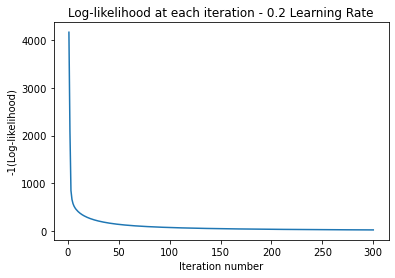

In [13]:
#preparing the iteration to look good as X label for the plot (from 1 to 300)
it=list(range(1,(iterations+1)))
#preparing to plot
fig, ax = plt.subplots()
ax.autoscale()
plt.title("Log-likelihood at each iteration - 0.2 Learning Rate")
plt.xlabel("Iteration number")
plt.ylabel("-1(Log-likelihood)")
plt.plot(it,L)
#ploting here in the notebook
plt.show()
#saving the plot to a .jpeg file
fig.savefig("plot.jpeg")

***
### Making predictions ###

Now that we have the best parameters ($w$) for our data we can use this vector to make classification predictions of our datasets. We can use both train and test sets, but be mindful that we estimated these parameters using the train set and therefore should expect the error estimates on that set to be smaller, if not zero! The real value of our model is evaluated with small error estimates on the test set, or unseen data!

We make predictions and then calculate the misclassification error using `sklearn` accuracy_score function. 

In [16]:
#Predicting and geting misclassification errors for train and test datasets
#Train set: x, y
#creating a list to store the predictions
y_predict = []
#transforming our prediction probabilities to 0 and 1
for row in x:
    score=np.dot(W,row)
    prob=math.exp(score) / 1+math.exp(score) #probability that observation in row is 1
    if (prob < 0.5):
        y_predict.append(0)
    else:
        y_predict.append(1)
#calculating the misclassification error as 1 - accuracy score
error = 1 - accuracy_score(y,y_predict)
    
#Test set: xtest, ytest
ytest_predict = []
for row in xtest:
    score=np.dot(W,row)
    prob=math.exp(score) / 1+math.exp(score) #probability that observation in row is 1
    if (prob < 0.5):
        ytest_predict.append(0)
    else:
        ytest_predict.append(1)

error_test = 1 - accuracy_score(ytest,ytest_predict)

print("Misclassification error for train data is {}, and for test data is {}".format(error, error_test))

Misclassification error for train data is 0.0, and for test data is 0.028000000000000025


***
## Using the Logit library ##

In this folder there is a file called `LogitFunctions.py` that cotains all the code above inside defined functions. We can use this file to run the Logistic Regression algorithm as shown below. We just need to import the Module/library as we do so many others and use the functions. There is already some difference from the functions above to the definitions in the file, since to run as a library all of the functions needed to work together, but all calculations are the same. Here we need only call the `logit_algorithm` function with the parameters needed:  

- $X$ data matrix, 
- $y$ vector of labels, 
- $\eta$, 
- $\lambda$ and 
- number of iterations we want.  

To see how well our model works on unseen data we just need to call the `y_predict` function with the following parameters:  
- $X$ test data matrix, 
- $y$ test label vector and 
- the $w$ vector of coeficients that we get from our algorithm function.  

The algorithm function also returns a list with all the log-likelihood scores from each iteration step that we can use to make a plot as we did before.  

One interesting feature of jupyter is that we can always start writing the name of the function we want and use `tab` to autocomplete it (after importing the module). And we can use `shift-tab` to get the function's docstrings, if we do that for `logit_algorithm` we can see which arguments it takes and if we click on the `+` button we can see everything. It is always good to be sure what are the values the function returns and plan your variables accordingly.

In [22]:
import LogitFunctions as logit

L, W = logit.logit_algorithm(x,y,0.3,0.0001,1000)
error = logit.y_predict(y,x,W)
error_test = logit.y_predict(ytest,xtest,W)

print("Misclassification error for train data is {}, and for test data is {}".format(error, error_test))

iteration = 0, L = 4158.883083360076
iteration = 10, L = 298.1320360493172
iteration = 20, L = 191.83915775116174
iteration = 30, L = 142.18581498288688
iteration = 40, L = 112.90963140039368
iteration = 50, L = 93.8669569368013
iteration = 60, L = 80.43637228767415
iteration = 70, L = 70.41814059457396
iteration = 80, L = 62.6437023493224
iteration = 90, L = 56.430081641771466
iteration = 100, L = 51.348315455384544
iteration = 110, L = 47.11425612162519
iteration = 120, L = 43.53182429557356
iteration = 130, L = 40.46120401742599
iteration = 140, L = 37.79996030160878
iteration = 150, L = 35.47130764061242
iteration = 160, L = 33.416545371175886
iteration = 170, L = 31.590025148835135
iteration = 180, L = 29.95571211119874
iteration = 190, L = 28.484779667544508
iteration = 200, L = 27.153892394439822
iteration = 210, L = 25.943957655915025
iteration = 220, L = 24.83920308960691
iteration = 230, L = 23.826484817954526
iteration = 240, L = 22.894761734555406
iteration = 250, L = 22.03

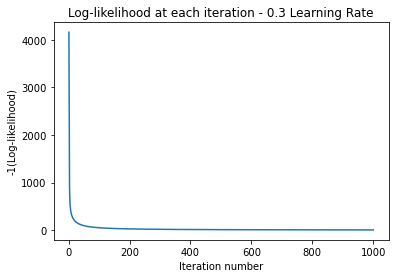

In [24]:
#preparing the iteration to look good as X label for the plot (from 1 to 300)
it=list(range(1,(1000+1)))
#preparing to plot
fig, ax = plt.subplots()
ax.autoscale()
plt.title("Log-likelihood at each iteration - 0.3 Learning Rate")
plt.xlabel("Iteration number")
plt.ylabel("-1(Log-likelihood)")
plt.plot(it,L)
#ploting here in the notebook
plt.show()
#saving the plot to a .jpeg file
fig.savefig("plot2.jpeg")